In [7]:
import torch
from torch import zeros
torch.set_default_dtype(torch.float64)
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style = 'white', color_codes = True)
%matplotlib inline

import sys
import os

import os
cwd = os.getcwd()

sys.path.append(cwd[:-len('befit/examples/temp_rev_learn')])

import pyro
pyro.enable_validation(True)

## Load behavioral data

In [2]:
df_res = pd.read_csv('pilot/responses.csv').set_index('subject')
responses = df_res.values[:, :-2].T.astype(float)

outcomes = pd.read_csv('pilot/outcomes.csv').set_index('subject').values.T.astype(float)
outcomes[np.nan_to_num(outcomes) < 2] = (outcomes[np.nan_to_num(outcomes) < 2] + 1)/2
outcomes[np.isnan(outcomes)] = 0.
corrects = pd.read_csv('pilot/correct_responses.csv').set_index('subject').values.T.astype(float)

states_and_rewards = io.loadmat('pilot/states_and_rewards.mat')
Sirr = states_and_rewards['irregular']['S'][0, 0][:, 0] - 1
Oirr = states_and_rewards['irregular']['R'][0, 0]
Sreg = states_and_rewards['regular']['S'][0, 0][:, 0] - 1
Oreg = states_and_rewards['regular']['R'][0, 0]

ns_reg = (df_res['condition'] == 'regular').sum()   # number of subjects in the regular reversals group
ns_irr = (df_res['condition'] == 'irregular').sum()  # number of subjects in the irregular reversals group

nsub = responses.shape[-1]

mask_all = torch.from_numpy(~np.isnan(responses)).unsqueeze(0)
responses_all = torch.from_numpy(np.nan_to_num(responses)).long().unsqueeze(0)
outcomes_all = torch.from_numpy(np.nan_to_num(outcomes)).long().unsqueeze(0)
offers_all = torch.ones(responses_all.shape, dtype=torch.long)
corrects_all = torch.from_numpy(corrects).unsqueeze(0)

In [3]:
# split participants on groups and exclude non-explorers
expl_subs = torch.sum(torch.squeeze(responses_all == 2), 0) > 20
expl_sub_num = torch.arange(nsub)[expl_subs]
reg_subs = expl_sub_num[expl_sub_num < ns_reg]
irr_subs = expl_sub_num[expl_sub_num >= ns_reg]

mask_c1 = mask_all[..., reg_subs]
mask_c2 = mask_all[..., irr_subs]

responses_c1 = responses_all[..., reg_subs]
responses_c2 = responses_all[..., irr_subs]

offers_c1 = offers_all[..., reg_subs]
offers_c2 = offers_all[..., irr_subs]

outcomes_c1 = outcomes_all[..., reg_subs]
outcomes_c2 = outcomes_all[..., irr_subs]

corr_c1 = corrects_all[..., reg_subs]
corr_c2 = corrects_all[..., irr_subs]

## Plotting functions

In [4]:
def errorplot(*args, **kwargs):
    subjects = args[0]
    values = args[1]
    percentiles = args[2]

    
    low_perc = values[percentiles == '5th']
    up_perc = values[percentiles == '95th']
    
    x = subjects[percentiles == 'median']
    y = values[percentiles == 'median']
    
    kwargs['yerr'] = [y.values-low_perc.values, up_perc.values-y.values]
    kwargs['linestyle'] = ''
    kwargs['marker'] = 'o'
    
    plt.errorbar(x.values, 
                 y.values, 
                 **kwargs)

## Fit behavioural models

In [5]:
from befit.agents import RLTempRevLearn, BayesTempRevLearn
from befit.inference import Horseshoe, NormalGamma, NormalGammaHierarch

In [8]:
# perform sequential parameter estimate and model selection
trials = 200

rl_agent_c1 = RLTempRevLearn(runs=responses_c1.shape[-1], trials=trials)
rl_agent_c1.set_parameters()

rl_agent_c2 = RLTempRevLearn(runs=responses_c2.shape[-1], trials=trials)
rl_agent_c2.set_parameters()

ps_rl_c1 = []
me_rl_c1 = []
ps_rl_c2 = []
me_rl_c2 = []
for i in range(11, 17):
    T1 = 50*i
    T2 = T1 + trials
    mask = mask_c1[:, T1:T2].clone()
    offers = offers_c1[:, T1:T2].clone()
    outcomes = outcomes_c1[:, T1:T2].clone()
    responses = responses_c1[:, T1:T2].clone()
    stimulus = {'offers': offers, 
                'outcomes': outcomes,
                'mask': mask.double()}
    
    mask[:, :20] = 0
    rl_infer = NormalGamma(rl_agent_c1, stimulus, responses, mask=mask)
    rl_infer.infer_posterior(iter_steps=200)
    
    labels = ['alpha', 'kappa', 'beta', 'theta']
    ps_rl_c1.append(rl_infer.sample_posterior(labels, n_samples=1000))
    
    me_rl_c1.append(rl_infer.get_log_evidence_per_subject(num_particles=200))
    
    mask = mask_c2[:, T1:T2].clone()
    offers = offers_c2[:, T1:T2].clone()
    outcomes = outcomes_c2[:, T1:T2].clone()
    responses = responses_c2[:, T1:T2].clone()
    stimulus = {'offers': offers, 
                'outcomes': outcomes,
                'mask': mask.double()}
    
    mask[:, :20] = 0
    rl_infer = NormalGamma(rl_agent_c2, stimulus, responses, mask=mask)
    rl_infer.infer_posterior(iter_steps=200)
    
    labels = ['alpha', 'kappa', 'beta', 'theta']
    ps_rl_c2.append(rl_infer.sample_posterior(labels, n_samples=1000))
    
    me_rl_c2.append(rl_infer.get_log_evidence_per_subject(num_particles=200))

Mean ELBO 3226.49: 100%|██████████| 200/200 [13:08<00:00,  3.15s/it]


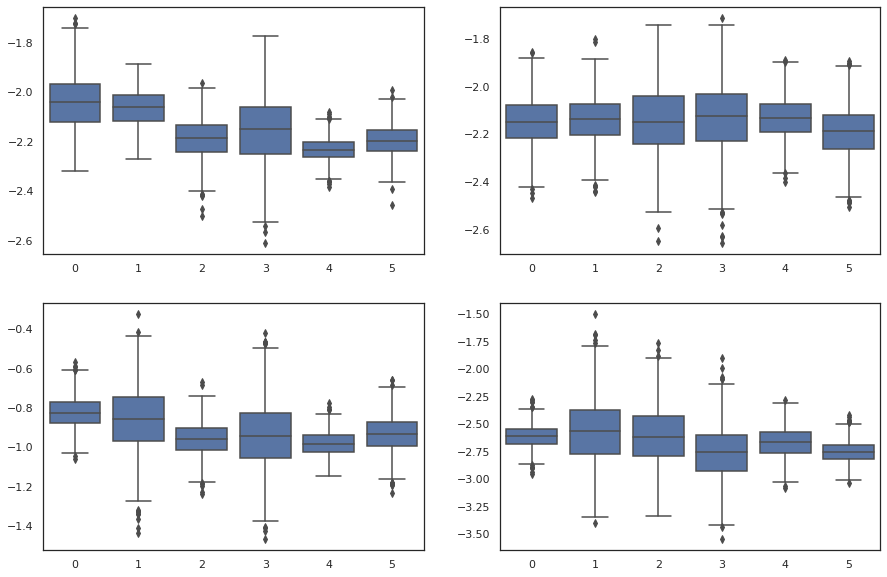

In [9]:
df_a = pd.DataFrame()
df_k = pd.DataFrame()
df_b = pd.DataFrame()
df_t = pd.DataFrame()
for n, sample in enumerate(ps_rl_c1):
    m_g = sample[1]
    df_a[n] = m_g['alpha']
    df_k[n] = m_g['kappa']
    df_b[n] = m_g['beta']
    df_t[n] = m_g['theta']

fig, axes = plt.subplots(2, 2, figsize=(15,10));
sns.boxplot(data=df_a, ax=axes[0,0], color='b');
sns.boxplot(data=df_k, ax=axes[0,1], color='b');
sns.boxplot(data=df_b, ax=axes[1,0], color='b');
sns.boxplot(data=df_t, ax=axes[1,1], color='b');

In [ ]:
# performe sequential parameter estimate and model selection
trials = 200

edhmm_agent_c1 = BayesTempRevLearn(runs=responses_c1.shape[-1], trials=trials)
edhmm_agent_c1.set_parameters()

edhmm_agent_c2 = BayesTempRevLearn(runs=responses_c2.shape[-1], trials=trials)
edhmm_agent_c2.set_parameters()

ps_edhmm_c1 = []
me_edhmm_c1 = []
ps_edhmm_c2 = []
me_edhmm_c2 = []

vals = zeros(responses_c1.shape[-1], 3)
fixed_params = {
    'labels': [4, 5, 6],
    'values': vals
}

for i in range(12, 14):
    T1 = 50*i
    T2 = T1 + trials
    mask = mask_c1[:, T1:T2].clone()
    offers = offers_c1[:, T1:T2].clone()
    outcomes = outcomes_c1[:, T1:T2].clone()
    responses = responses_c1[:, T1:T2].clone()
    stimuli = {'offers': offers, 
                'outcomes': outcomes,
                'mask': mask.double()}
    
    edhmm_infer = NormalGamma(edhmm_agent_c1, stimuli, responses, mask=mask, fixed_params=fixed_params)
    edhmm_infer.infer_posterior(iter_steps=300)
    
    labels = ['mu', 'sigma', 'beta', 'lam']
    ps_edhmm_c1.append(edhmm_infer.sample_posterior(labels, n_samples=1000))
    me_edhmm_c1.append(edhmm_infer.get_log_evidence_per_subject(num_particles=200))
    
    mask = mask_c2[:, T1:T2].clone()
    offers = offers_c2[:, T1:T2].clone()
    outcomes = outcomes_c2[:, T1:T2].clone()
    responses = responses_c2[:, T1:T2].clone()
    stimuli = {'offers': offers, 
                'outcomes': outcomes,
                'mask': mask.double()}
    
    edhmm_infer = NormalGamma(edhmm_agent_c2, stimuli, responses, mask=mask, fixed_params=fixed_params)
    edhmm_infer.infer_posterior(iter_steps=300)
    
    labels = ['mu', 'sigma', 'beta', 'lam']
    ps_edhmm_c2.append(edhmm_infer.sample_posterior(labels, n_samples=1000))
    me_edhmm_c2.append(edhmm_infer.get_log_evidence_per_subject(num_particles=200))

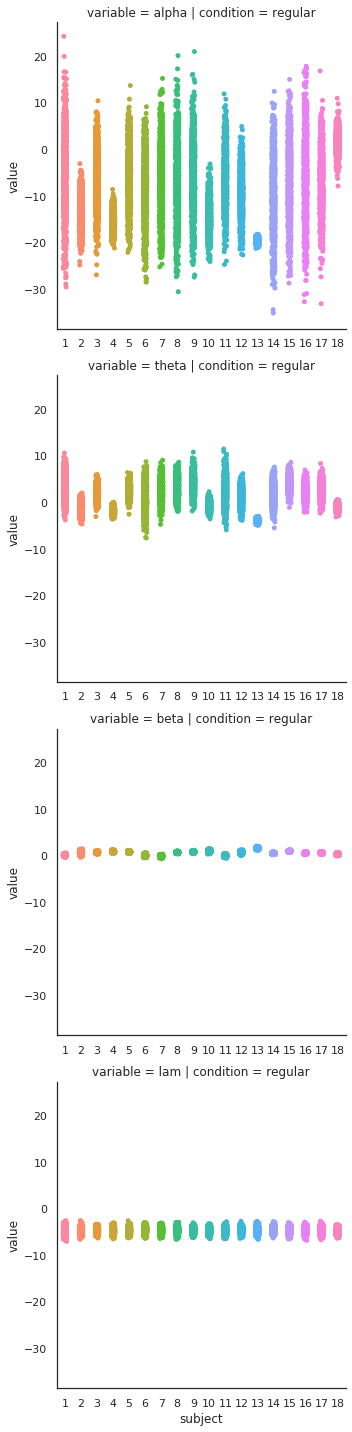

In [13]:
step = 0

data1 = pd.melt(ps_edhmm_c1[step][0], id_vars=['subject'], value_vars=['alpha', 'theta', 'beta', 'lam'])
data1['condition'] = 'regular'

# data2 = pd.melt(ps_edhmm_c2[step][0], id_vars=['subject'], value_vars=['alpha', 'theta', 'beta', 'lam', 'c0'])
# data2['condition'] = 'irregular'

# data = data1.append(data2, ignore_index=True)

sns.catplot(x='subject', y='value', data=data1, row='variable', col='condition', sharex=False);

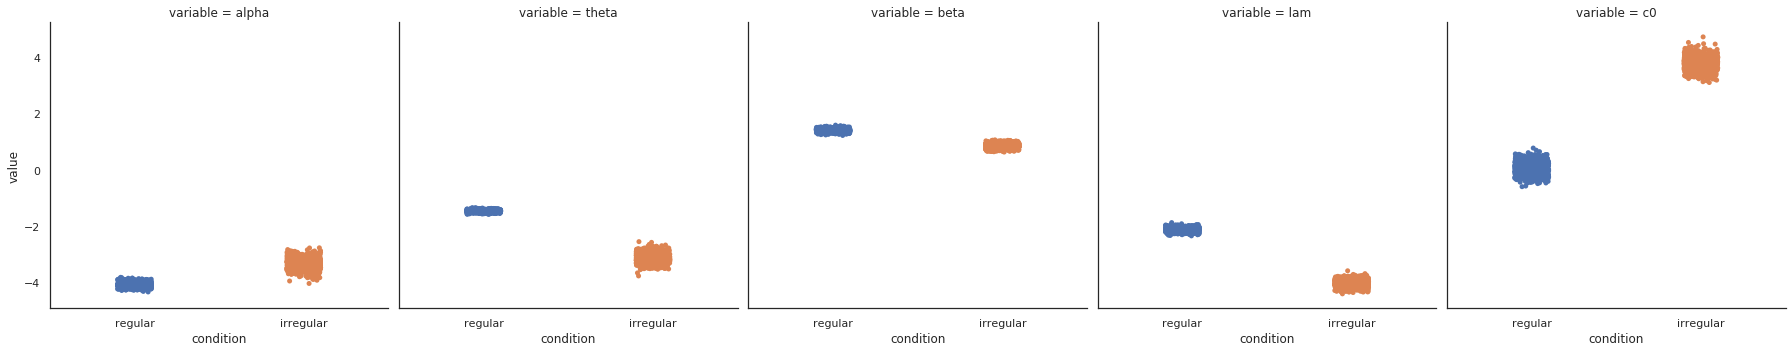

In [88]:
step = 0

data1 = pd.melt(ps_edhmm_c1[step][1], value_vars=['alpha', 'theta', 'beta', 'lam', 'c0'])
data1['condition'] = 'regular'

data2 = pd.melt(ps_edhmm_c2[step][1], value_vars=['alpha', 'theta', 'beta', 'lam', 'c0'])
data2['condition'] = 'irregular'

data = data1.append(data2, ignore_index=True)

sns.catplot(x='condition', y='value', data=data, col='variable');

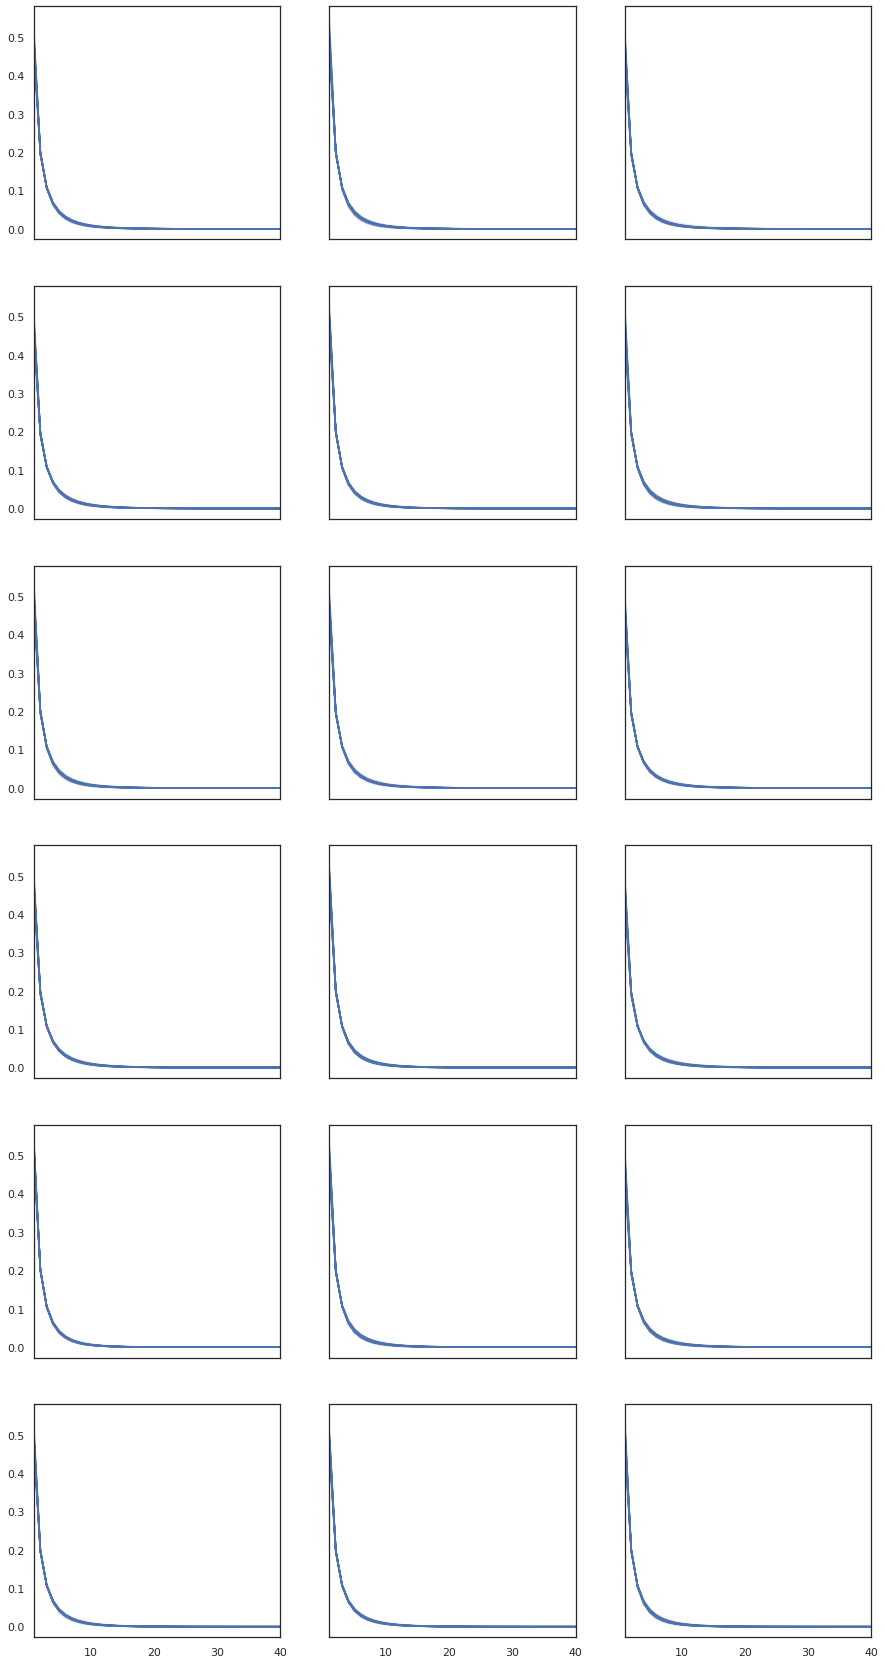

In [90]:
softplus = torch.nn.functional.softplus

step = 0
nd = 100
x = ps_edhmm_c1[step][0].values[:, :-1].reshape(1000, 18, -1)
alpha = softplus(torch.tensor(x[..., 0]))
theta = softplus(torch.tensor(x[..., 1]))

d = torch.arange(1., nd + 1.)
lnd = d.log()

prior_d = torch.softmax(lnd.reshape(1, 1, -1) * (alpha.reshape(1000, 18, 1) - 1)\
                   - d.reshape(1, 1, -1) * theta.reshape(1000, 18, 1), -1)

fig, axes = plt.subplots(6, 3, figsize=(15, 30), sharex=True, sharey=True)
for i in range(3):
    for j in range(6):
        sub = j*3 + i
        axes[j, i].plot(d.numpy(), prior_d[::10, sub].numpy().T, c='b', alpha=.1);
        axes[j, i].set_xlim([1, 40])

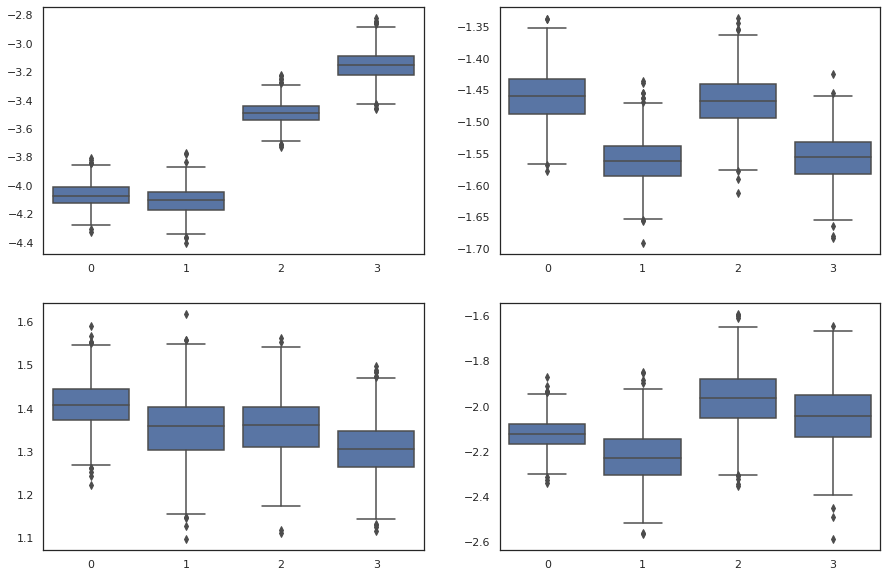

In [92]:
df_d = pd.DataFrame()
df_r = pd.DataFrame()
df_b = pd.DataFrame()
df_l = pd.DataFrame()
df_ph = pd.DataFrame()
df_pl = pd.DataFrame()
for n, sample in enumerate(ps_edhmm_c1):
    m_g = sample[1]
    df_d[n] = m_g['alpha']
    df_r[n] = m_g['theta']
    df_b[n] = m_g['beta']
    df_l[n] = m_g['lam']
#     df_ph[n] = m_g['ph']
#     df_pl[n] = m_g['pl']

fig, axes = plt.subplots(2, 2, figsize=(15,10));
sns.boxplot(data=df_d, ax=axes[0,0], color='b');
sns.boxplot(data=df_r, ax=axes[0,1], color='b');
sns.boxplot(data=df_b, ax=axes[1,0], color='b');
sns.boxplot(data=df_l, ax=axes[1,1], color='b');
# sns.boxplot(data=df_ph, ax=axes[1,1], color='b');
# sns.boxplot(data=df_pl, ax=axes[1,1], color='b');

In [93]:
def get_reversal_statistics(responses, corrects, states, nsub, delta=200):
    trials = len(states)
    
    A = responses.T == 2
    C = corrects.T

    reversal = np.abs(np.diff(states.flatten())).astype(bool)
    trials = np.arange(1, trials)[reversal]
    perf = {}
    expl = {}
    for t in trials:
        block = np.long(np.floor(t/delta))
        perf.setdefault(block, [])
        perf[block].append(np.nanmean(C[:,t-10:t+10], 0))
        
        expl.setdefault(block, [])
        expl[block].append(np.nanmean(A[:,t-10:t+10], 0))
    
    return perf, expl

In [95]:
# posterior predictive check

blocks = 1 # number of blocks
trials = 200  # number of samples

from torch import zeros, ones, tensor

from befit.tasks import TempRevLearn
from befit.agents import BayesTempRevLearn
from befit.simulate import Simulator

ns1 = torch.sum(~non_expl[:ns_reg]).item()
ns2 = torch.sum(~non_expl[ns_reg:]).item()

n_samples = 100

perf = {'reg': {}, 'irr': {}}
expl = {'reg': {}, 'irr': {}}
for step in range(1):
    T1 = 50*step
    T2 = T1 + trials
    reg_rewards = torch.from_numpy(Oreg[T1:T2]).reshape(1, trials, 1, 2).repeat(1, 1, ns1, 1)
    reg_rewards = ((reg_rewards + 1)/2).long()
    irr_rewards = torch.from_numpy(Oirr[T1:T2]).reshape(1, trials, 1, 2).repeat(1, 1, ns2, 1)
    irr_rewards = ((irr_rewards + 1)/2).long()

    reg_states = torch.from_numpy(Sreg[T1:T2]).reshape(1, trials, 1).repeat(1, 1, ns1).long()
    irr_states = torch.from_numpy(Sirr[T1:T2]).reshape(1, trials, 1).repeat(1, 1, ns2).long()
    
    reg_off = zeros(blocks, trials, ns1, dtype=torch.long)
    
    reg_stimuli = {'states': reg_states, 
                   'rewards': reg_rewards, 
                   'offers': reg_off}

    reg_temprev = TempRevLearn(reg_stimuli, nsub=ns1)
    
    irr_off = zeros(blocks, trials, ns2, dtype=torch.long)

    irr_stimuli = {'states': irr_states, 
                   'rewards': irr_rewards, 
                   'offers': reg_off}

    irr_temprev = TempRevLearn(irr_stimuli, nsub=ns2)
    
    for key in perf:
        perf[key].setdefault(0, [])
        expl[key].setdefault(0, [])
    
    for n in range(n_samples):
        trans_pars1 = torch.tensor(ps_edhmm_c1[step][0].values[:, :-1]).reshape(1000, ns1, -1)[n]
        
        tp = zeros(ns1, 7)
        tp[:, :-2] = trans_pars1
        
        edhmm_agent1 = BayesTempRevLearn(runs=ns1, trials=trials)
        edhmm_agent1.set_parameters(tp)

        sim1 = Simulator(reg_temprev, edhmm_agent1, runs=ns1, trials=trials)
        sim1.simulate_experiment()
        sim1.format_stimuli_and_responses();
        
        trans_pars2 = torch.tensor(ps_edhmm_c2[step][0].values[:, :-1]).reshape(1000, ns2, -1)[n]
        tp = zeros(ns1, 7)
        tp[:, :-2] = trans_pars2
        
        edhmm_agent2 = BayesTempRevLearn(runs=ns2, trials=trials)
        edhmm_agent2.set_parameters(tp)
        
        sim2 = Simulator(irr_temprev, edhmm_agent2, runs=ns2, trials=trials)
        sim2.simulate_experiment()
        sim2.format_stimuli_and_responses();
        
        res1 = sim1.responses
        corrects1 = (reg_states == res1).float()  # correct responses in condition reg->irr
        corrects1[res1 == 2] = np.nan
        mask = mask_c1[:, T1:T2]
        corrects1[~mask] = np.nan
        corrects1 = corrects1[0].numpy()
        res1 = res1.float()
        res1[~mask] = np.nan
        responses1 = res1.numpy()[0]
        

        res2 = sim2.responses
        corrects2 = (irr_states == res2).float()  # correct responses in condition irr->reg
        corrects2[res2 == 2] = np.nan
        mask = mask_c2[:, T1:T2]
        corrects2[~mask] = np.nan
        corrects2 = corrects2[0].numpy()
        res2 = res2.float()
        res2[~mask] = np.nan
        responses2 = res2.numpy()[0]
        
        for key in perf:
            if key == 'reg':
                p, e = get_reversal_statistics(responses1, corrects1, Sreg, ns1)
            else:
                p, e = get_reversal_statistics(responses2, corrects2, Sirr, ns2)
                
            perf[key][step].append(p)
            expl[key][step].append(e)      

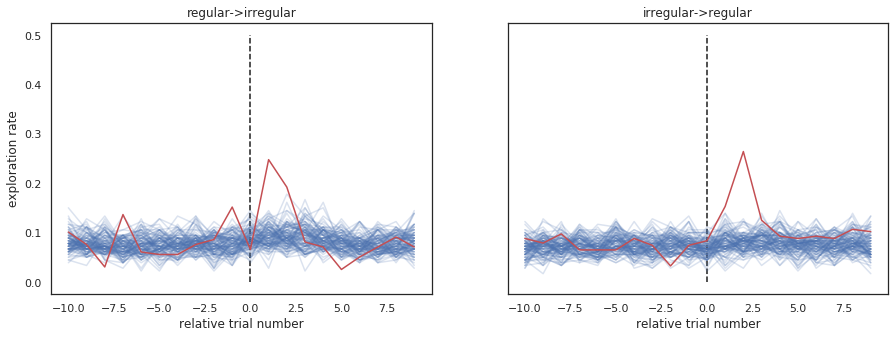

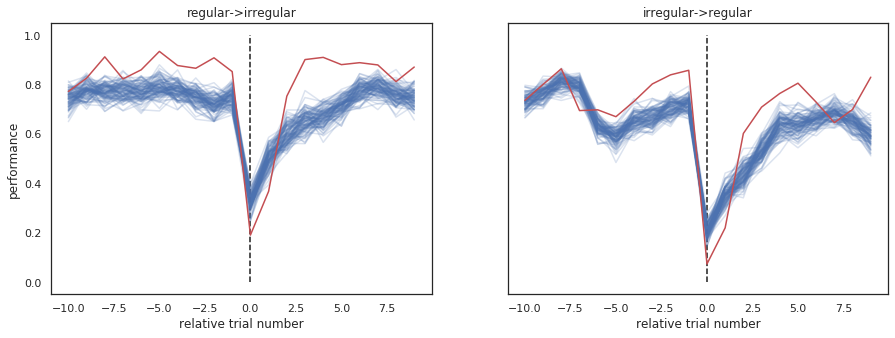

In [96]:
reg_res = responses_c1[0]
irr_res = responses_c2[0]

reg_corr = corr_c1[0]
irr_corr = corr_c2[0]

# get the response statistics from the behavioural data
nsub = reg_res.shape[-1]
reg_perf, reg_expl = get_reversal_statistics(reg_res, reg_corr, Sreg, nsub)

nsub = irr_res.shape[-1]
irr_perf, irr_expl = get_reversal_statistics(irr_res, irr_corr, Sirr, nsub)

t = np.arange(-10, 10)

# plot superimposed behavioural and simulated response data
step = 0
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)
block = 0
t = np.arange(-10, 10)

for n in range(n_samples):
    for i, key in enumerate(expl):
        e = expl[key][step][n][block]
        axes[i].plot(t, np.mean(np.vstack(e), 0), alpha=.2, c='b')
axes[0].plot(t, np.mean(reg_expl[3], 0), 'r')
axes[1].plot(t, np.mean(irr_expl[3], 0), 'r')
    
axes[0].vlines(0, 0., .5, 'k', linestyle='--');
axes[1].vlines(0, 0., .5, 'k', linestyle='--');
axes[0].set_xlabel('relative trial number');
axes[1].set_xlabel('relative trial number');
axes[0].set_title('regular->irregular');
axes[1].set_title('irregular->regular');
axes[0].set_ylabel('exploration rate');

fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)
for n in range(n_samples):
    for i, key in enumerate(expl):
        p = perf[key][step][n][block]
        axes[i].plot(t, np.mean(np.vstack(p), 0), alpha=.2, c='b')

axes[0].plot(t, np.mean(reg_perf[3], 0), 'r')
axes[1].plot(t, np.mean(irr_perf[3], 0), 'r')

axes[0].vlines(0, 0., 1., 'k', linestyle='--');
axes[1].vlines(0, 0., 1., 'k', linestyle='--');
axes[0].set_xlabel('relative trial number');
axes[1].set_xlabel('relative trial number');
axes[0].set_title('regular->irregular');
axes[1].set_title('irregular->regular');
axes[0].set_ylabel('performance');